In [63]:
# https://github.com/NeuroSyd/seizure-prediction-GAN/blob/master/utils/load_signals.py
import os
import mne
import numpy as np
import matplotlib.pyplot as plt


In [92]:
data_dir = 'data/chb-mit-scalp-eeg-database-1.0.0'
data_dir = 'data/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_06.edf'

In [97]:
a = load_data(data_dir,0,2000)
a

<RawArray | 21 x 512001 (2000.0 s), ~82.1 MB, data loaded>

Setting up low-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB



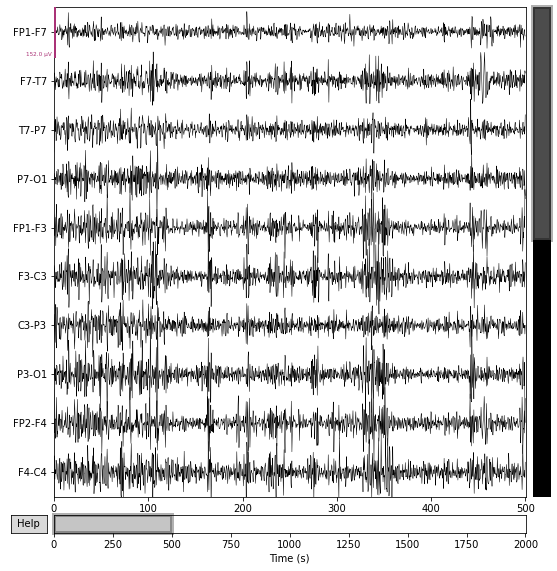

In [98]:
a.plot(duration=500, n_channels=10,scalings='auto',lowpass=True)
plt.show()

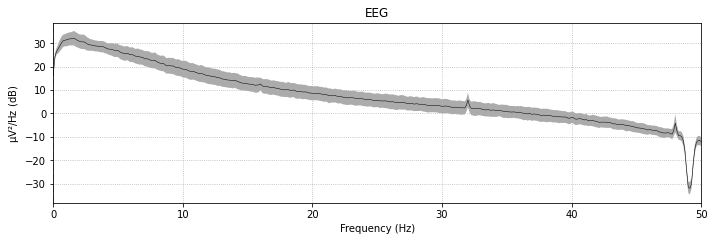

In [102]:
a.plot_psd(fmax=50,average=True)
plt.show()

In [59]:
def load_data(path, start, stop):
    """
    Uses MNE-toolbox to load the data. Apply noth filter at 50 Hz
    Input: path to file, start and stop in seconds as float
    output: the MNE.io.Raw object that contains the given time intervall
    """
    # check if path exist and then load the object with mne
    if os.path.exists(data_dir):

        raw = mne.io.read_raw_edf(path, exclude=['-', 'T8-P8', '.'], verbose=False, preload=True)

        # apply notch filter around 50 Hz.
        raw.notch_filter(freqs=[49.1, 50.9])

        # Stim channel is automatically created by MNE.
        #raw.drop_channels(['STI 014'])

        # Take 30 seconds before onset
        #start = start - 
        #stop = start + 150
        # check if the recording is long enough to create the feature vector
        if raw.n_times // 256 > start + 150:
            try:
                cropped = raw.crop(start, stop, verbose=False)
            except:
                # Sometime something goes wrong so I manually extract the seizure of the timewindow and return a
                # newly created object with the info
                manual_raw = raw.get_data()
                freq = raw.info['sfreq']
                manual_start = int(start * freq)
                manual_stop = int((stop * freq + 1))
                manual_data = np.asarray([manual_raw[i][manual_start:manual_stop] for i in range(len(manual_raw))])
                cropped = mne.io.RawArray(manual_data, raw.info, verbose=False)

        return cropped